# Building gradients

This section describes how to generate macroscale gradient mapping from the output matrices of micapipe. The matrices are the same as in the [`Main output matrices`](https://micapipe.readthedocs.io/en/latest/pages/04.matrices/index.html) tutorial.

For this tutorial we will map each modality of a single subject using `brainspace`, a `python` based library.

For further information about how to use `brainspace` and macroscale gradient mapping and analysis of neuroimaging and connectome level data visit their documentation here: [BrainSpace documentation](https://brainspace.readthedocs.io/en/latest/index.html).

Additionally the libraries `os`, `numpy`, `nibabel` and `matplotlib` will be used.

As in previous examples, we will use the subject `HC001`, session `01` from the MICs dataset, and all paths will be relative to the subject directory or `out/micapipe_v0.2.0/sub-HC001_ses01/` and the atlas `schaefer-400`.

In this tutorial we will only plot the first 3 components of the diffusion map embedding (aka gradients).

For further references about **diffusion map embedding** check:
> - Coifman & Lafon. Diffusion maps. Applied and computational harmonic analysis. 2006 Jul 1;21(1):5-30. https://doi.org/10.1016/j.acha.2006.04.006
> - Vos de Wael, Benkarim, et al. BrainSpace: a toolbox for the analysis of macroscale gradients in neuroimaging and connectomics datasets. Commun Biol 3, 103 (2020). https://doi.org/10.1038/s42003-020-0794-7

## Set the enviroment

The first step is to set the python environment and all the variables relative to the subject you're interested to visualize.


In [1]:
# Set the environment
import os
import glob
import numpy as np
import nibabel as nib
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt

# Set the working directory to the 'out' directory
out='/data_/mica3/BIDS_MICs/derivatives'
os.chdir(out)     # <<<<<<<<<<<< CHANGE THIS PATH

# This variable will be different for each subject
sub='HC001' # <<<<<<<<<<<< CHANGE THIS SUBJECT's ID
ses='01'    # <<<<<<<<<<<< CHANGE THIS SUBJECT's SESSION
subjectID=f'sub-{sub}_ses-{ses}'           
subjectDir=f'micapipe_v0.2.0/sub-{sub}/ses-{ses}' 

# Here we define the atlas 
atlas='schaefer-400' # <<<<<<<<<<<< CHANGE THIS ATLAS

# Path to MICAPIPE from global enviroment
micapipe=os.popen("echo $MICAPIPE").read()[:-1] # <<<<<<<<<<<< CHANGE THIS PATH


### Load the surfaces

In [2]:
# Load fsLR-32k
f32k_lh, f32k_rh = load_conte69()

# Load fsaverage5
fs5_lh = read_surface('freesurfer/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface('freesurfer/fsaverage5/surf/rh.pial', itype='fs')

# Load LEFT annotation file in fsaverage5
annot_lh_fs5= nib.freesurfer.read_annot(f'{micapipe}/parcellations/lh.'+atlas+'_mics.annot')

# Unique number of labels of a given atlas
Ndim = max(np.unique(annot_lh_fs5[0]))

# Load RIGHT annotation file in fsaverage5
annot_rh_fs5= nib.freesurfer.read_annot(f'{micapipe}/parcellations/rh.'+atlas+'_mics.annot')[0]+Ndim

# replace with 0 the medial wall of the right labels
annot_rh_fs5 = np.where(annot_rh_fs5==Ndim, 0, annot_rh_fs5) 

# fsaverage5 labels
labels_fs5 = np.concatenate((annot_lh_fs5[0], annot_rh_fs5), axis=0)

# Mask of the medial wall on fsaverage 5
mask_fs5 = labels_fs5 != 0

# Read label for fsLR-32k
labels_f32k = np.loadtxt(open(f'{micapipe}/parcellations/{atlas}_conte69.csv'), dtype=int)

# mask of the medial wall
mask_f32k = labels_f32k != 0


### Global variables

In [3]:
# Number of gradients to calculate
Ngrad=10

# Number of gradients to plot
Nplot=3

# Labels for plotting based on Nplot
labels=['G'+str(x) for x in list(range(1,Nplot+1))]

# Gradients from atlas based connectomes: single subject

## Geodesic distance
### Load and slice the GD matrix

In [4]:
# Set the path to the the geodesic distance connectome
gd_file = f'{subjectDir}/dist/{subjectID}_atlas-{atlas}_GD.shape.gii'

# Load the cortical connectome
mtx_gd = nib.load(gd_file).darrays[0].data

# Remove the Mediall Wall
mtx_gd = np.delete(np.delete(mtx_gd, 0, axis=0), 0, axis=1)
GD = np.delete(np.delete(mtx_gd, Ndim, axis=0), Ndim, axis=1)


### Calculate the GD gradients

In [5]:
# GD Left hemi
gm_GD_L = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gm_GD_L.fit(GD[0:Ndim, 0:Ndim], sparsity=0.8)

# GD Right hemi
gm_GD_R = GradientMaps(n_components=Ngrad, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
gm_GD_R.fit(GD[Ndim:Ndim*2, Ndim:Ndim*2], sparsity=0.85, reference=gm_GD_L.gradients_)


GradientMaps(alignment='procrustes', kernel='normalized_angle')

### Plot the GD gradients

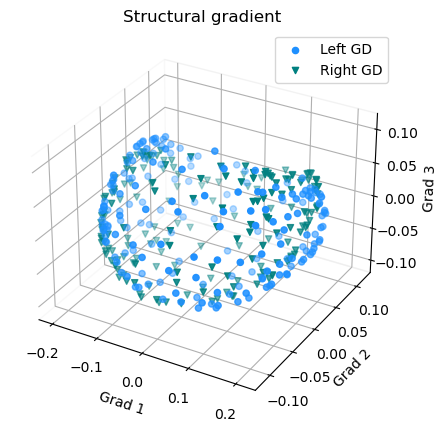

In [6]:
# plot the gradients
g1=gm_GD_L.gradients_[:, 0]
g2=gm_GD_L.gradients_[:, 1]
g3=gm_GD_L.gradients_[:, 2]

# plot the gradients
g1R=gm_GD_R.aligned_[:, 0]
g2R=gm_GD_R.aligned_[:, 1]
g3R=gm_GD_R.aligned_[:, 2]

# Creating figure
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

# Creating plot
ax.scatter3D(g1, g2, g3, color = 'dodgerblue')
ax.scatter3D(g1R, g2R, g3R, color = 'teal', marker='v')
plt.title("Structural gradient")
ax.legend(['Left GD', 'Right GD'])

ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')

# Remove the outer box lines
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Show plot
plt.show()

### GD gradients on `fsaverage5` surface

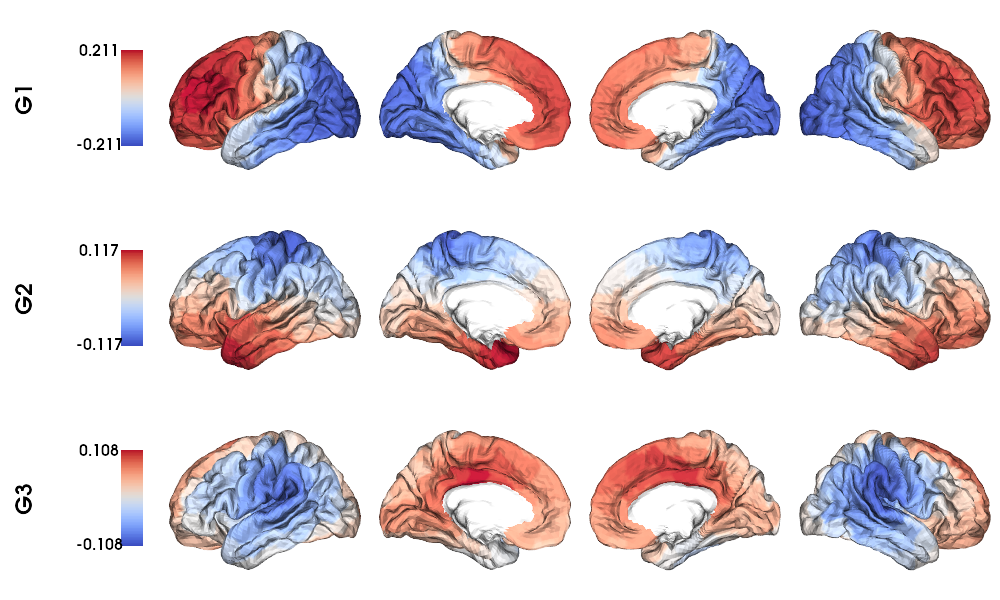

In [7]:
# Left and right gradients concatenated
GD_gradients = np.concatenate((gm_GD_L.gradients_, gm_GD_R.aligned_), axis=0)

# Map gradients to original parcels
grad = [None] * Nplot
for i, g in enumerate(GD_gradients.T[0:Nplot,:]):
    grad[i] = map_to_labels(g, labels_fs5,  fill=np.nan, mask=mask_fs5)
    
# Plot Gradients RdYlBu
plot_hemispheres(fs5_lh, fs5_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':labels}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1), color_range = 'sym' )

### GD gradients on `fsLR-32k` surface

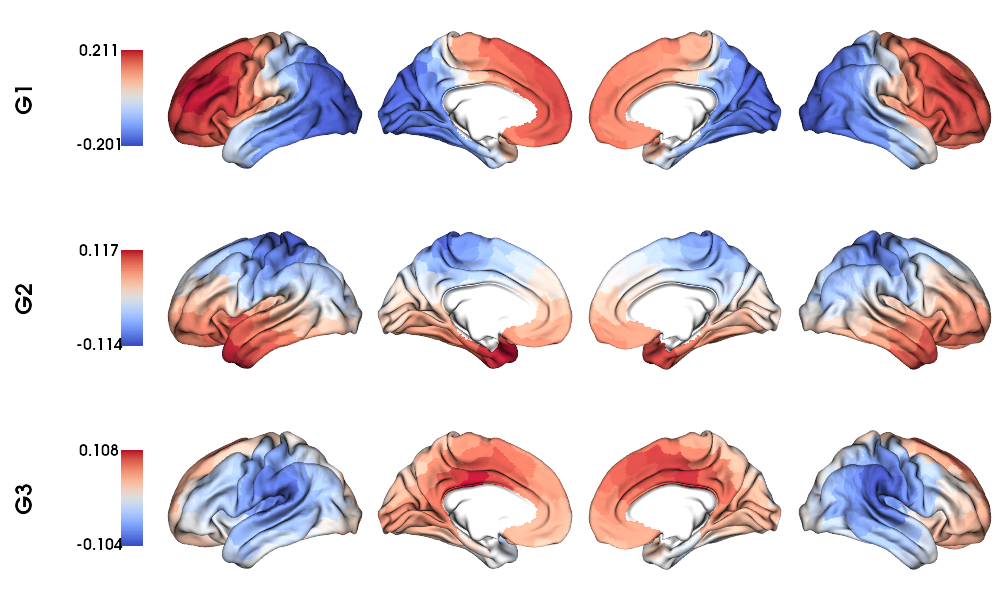

In [8]:
# Map gradients to original parcels
grad = [None] * Nplot
for i, g in enumerate(GD_gradients.T[0:Nplot,:]):
    grad[i] = map_to_labels(g, labels_f32k, fill=np.nan, mask=mask_f32k)

# Plot Gradients
plot_hemispheres(f32k_lh, f32k_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':labels}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1))


## Structural gradients
### Load and slice the structural matrix

In [9]:
# Set the path to the the structural cortical connectome
sc_file = f'{subjectDir}/dwi/connectomes/{subjectID}_space-dwi_atlas-{atlas}_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii'

# Load the cortical connectome
mtx_sc = nib.load(sc_file).darrays[0].data

# Fill the lower triangle of the matrix
mtx_sc = np.log(np.triu(mtx_sc,1)+mtx_sc.T)
mtx_sc[np.isneginf(mtx_sc)] = 0

# Slice the connectome to use only cortical nodes
SC = mtx_sc[49:, 49:]
SC = np.delete(np.delete(SC, 200, axis=0), 200, axis=1)


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_11714/2136732103.py:8: RuntimeWarning: divide by zero encountered in log
  mtx_sc = np.log(np.triu(mtx_sc,1)+mtx_sc.T)


### Calculate the structural gradients

In [10]:
# SC Left hemi
gm_SC_L = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gm_SC_L.fit(SC[0:Ndim, 0:Ndim], sparsity=0.9)

# SC Right hemi
gm_SC_R = GradientMaps(n_components=Ngrad, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
gm_SC_R.fit(SC[Ndim:Ndim*2, Ndim:Ndim*2], sparsity=0.9, reference=gm_SC_L.gradients_)


GradientMaps(alignment='procrustes', kernel='normalized_angle')

### Plot the structural gradients

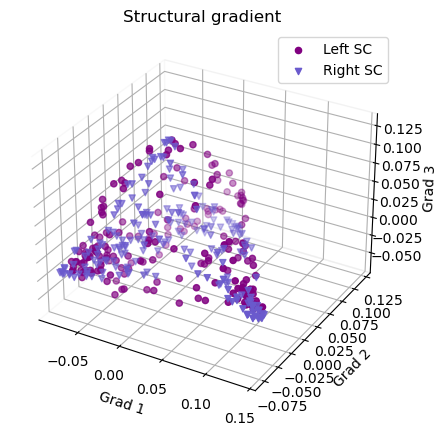

In [11]:
# plot the left gradients
g1=gm_SC_L.gradients_[:, 0]
g2=gm_SC_L.gradients_[:, 1]
g3=gm_SC_L.gradients_[:, 2]

# plot the right gradients
g1R=gm_SC_R.aligned_[:, 0]
g2R=gm_SC_R.aligned_[:, 1]
g3R=gm_SC_R.aligned_[:, 2]

# Creating figure
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

# Creating plot
ax.scatter3D(g1, g2, g3, color = 'purple')
ax.scatter3D(g1R, g2R, g3R, color = 'slateblue', marker='v')
plt.title("Structural gradient")
ax.legend(['Left SC', 'Right SC'])

ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')

# Remove the outer box lines
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Show plot
plt.show()

### Structural gradients on `fsLR-32k` surface

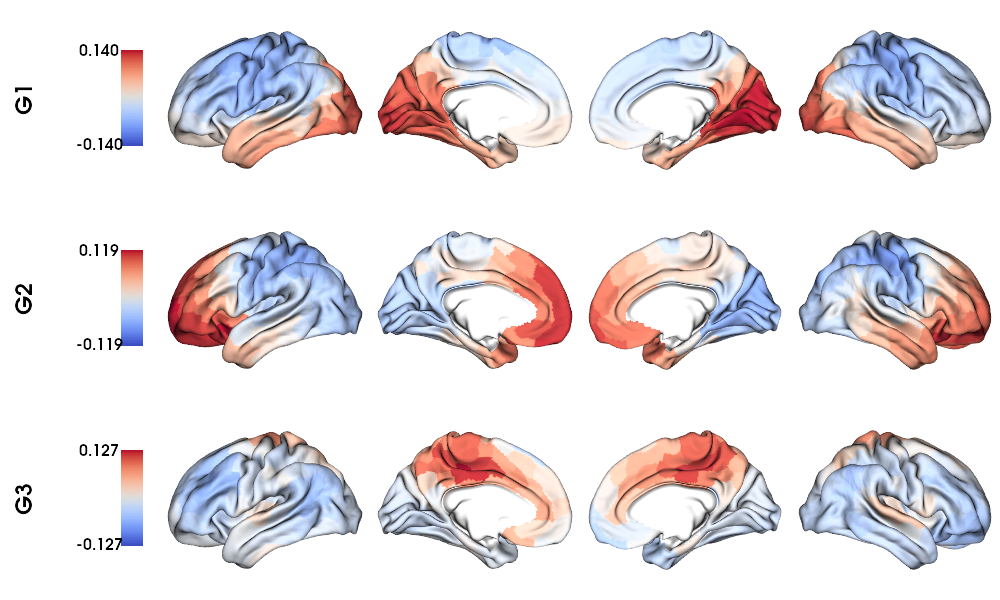

In [12]:
# Left and right gradients concatenated
SC_gradients = np.concatenate((gm_SC_L.gradients_, gm_SC_R.aligned_), axis=0)

# Map gradients to original parcels
grad = [None] * Nplot
for i, g in enumerate(SC_gradients.T[0:Nplot,:]):
    grad[i] = map_to_labels(g, labels_f32k, fill=np.nan, mask=mask_f32k)

# Plot Gradients
plot_hemispheres(f32k_lh, f32k_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':labels}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1), color_range = 'sym' )


## Functional gradients
### Load and slice the functional matrix

In [13]:
# acquisitions
func_acq='desc-se_task-rest_acq-AP_bold'
fc_file = f'{subjectDir}/func/{func_acq}/surf/{subjectID}_surf-fsLR-32k_atlas-{atlas}_desc-FC.shape.gii'

# Load the cortical connectome
mtx_fs = nib.load(fc_file).darrays[0].data

# slice the matrix to keep only the cortical ROIs
FC = mtx_fs[49:, 49:]
#FC = np.delete(np.delete(FC, Ndim, axis=0), Ndim, axis=1)

# Fischer transformation
FCz = np.arctanh(FC)

# replace inf with 0
FCz[~np.isfinite(FCz)] = 0

# Mirror the matrix
FCz = np.triu(FCz,1)+FCz.T

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_11714/1788303592.py:13: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(FC)


### Calculate the functional gradients

In [14]:
# Calculate the gradients
gm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gm.fit(FCz, sparsity=0.85)

GradientMaps(kernel='normalized_angle')

### Plot the functional gradients

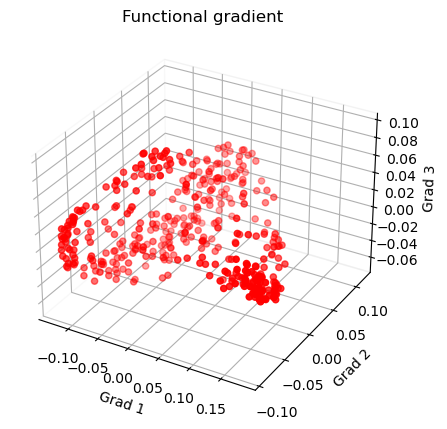

In [15]:
# Plot the gradients
g1 = gm.gradients_[:, 0]
g2 = gm.gradients_[:, 1]
g3 = gm.gradients_[:, 2]

# Creating figure
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

# Creating plot
ax.scatter3D(g1, g2, g3, color='red')
plt.title("Functional gradient")

ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')

# Remove the outer box lines
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Show plot
plt.show()

### Functional gradients on `fsLR-32k` surface

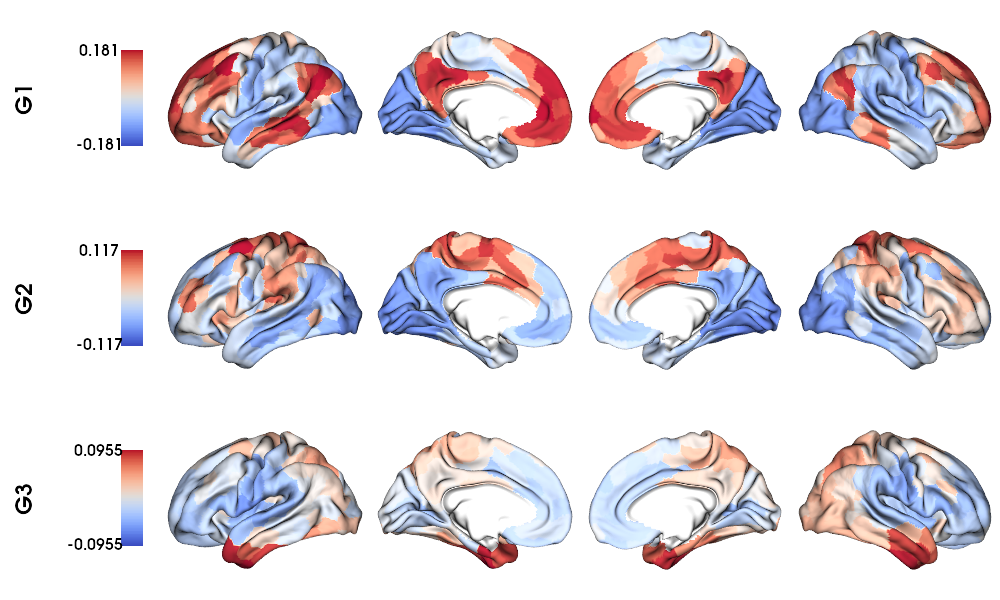

In [16]:
# Map gradients to original parcels
grad = [None] * Nplot
for i, g in enumerate(gm.gradients_.T[0:Nplot,:]):
    grad[i] = map_to_labels(g, labels_f32k, fill=np.nan, mask=mask_f32k)

# Plot Gradients coolwarm
plot_hemispheres(f32k_lh, f32k_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':labels}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1), color_range = 'sym')

## MPC gradients
### Function to load MPC

In [17]:
# Define a function to load and process the MPC matrices
def load_mpc(File, Ndim):
    """Loads and process a MPC"""

    # Load file
    mpc = nib.load(File).darrays[0].data
    
    # Mirror the lower triangle
    mpc = np.triu(mpc,1)+mpc.T
    
    # Replace infinite values with epsilon
    mpc[~np.isfinite(mpc)] = np.finfo(float).eps
    
    # Replace 0 with epsilon
    mpc[mpc==0] = np.finfo(float).eps
    
    # Remove the medial wall
    mpc = np.delete(np.delete(mpc, 0, axis=0), 0, axis=1)
    mpc = np.delete(np.delete(mpc, Ndim, axis=0), Ndim, axis=1)
    
    # retun the MPC
    return(mpc)

### List and load the MPC matrix

In [18]:
# Set the path to the the MPC cortical connectome
mpc_acq='acq-T1map'
mpc_file = f'{subjectDir}/mpc/{mpc_acq}/{subjectID}_atlas-{atlas}_desc-MPC.shape.gii'

# Load the cortical connectome
mpc = load_mpc(mpc_file, Ndim)


### Calculate the MPC gradients

In [19]:
# Calculate the gradients
gm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gm.fit(mpc, sparsity=0)

GradientMaps(kernel='normalized_angle')

### Plot the MPC gradients

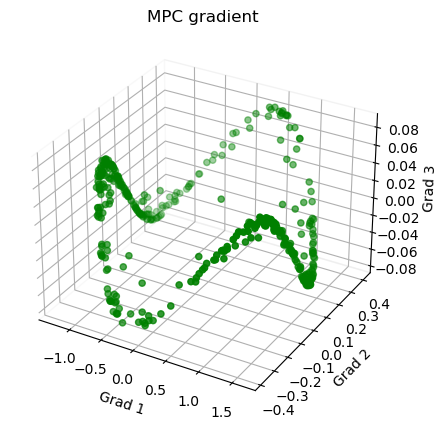

In [20]:
# Plot the gradients
g1 = gm.gradients_[:, 0]
g2 = gm.gradients_[:, 1]
g3 = gm.gradients_[:, 2]

# Creating figure
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

# Creating plot
ax.scatter3D(g1, g2, g3, color = 'green')
plt.title("MPC gradient")

ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')

# Remove the outer box lines
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Show plot
plt.show()

### MPC gradients on `fsLR-32k` surface

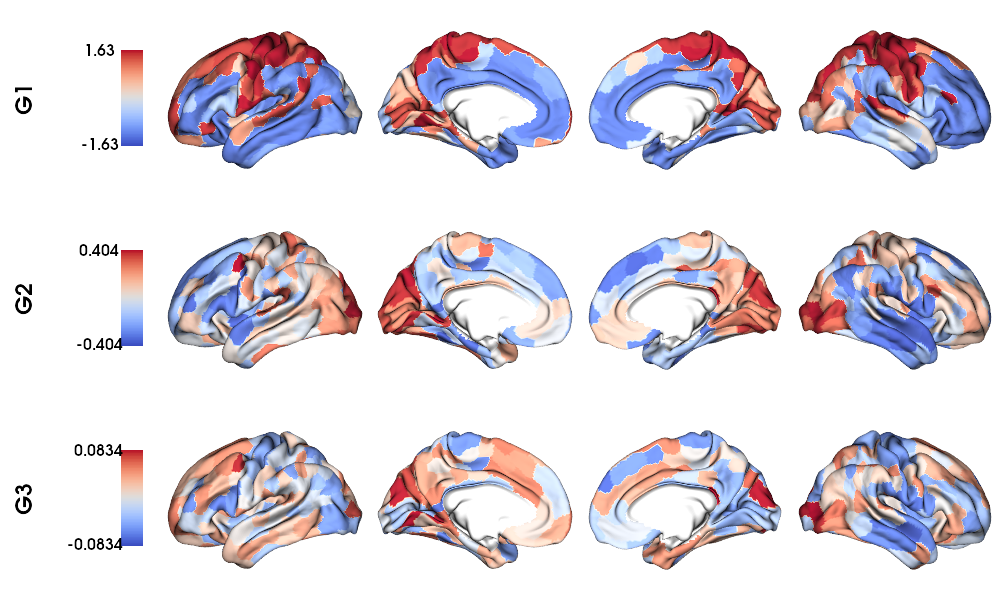

In [21]:
# Map gradients to original parcels
grad = [None] * Nplot
for i, g in enumerate(gm.gradients_.T[0:Nplot,:]):
    grad[i] = map_to_labels(g, labels_f32k, fill=np.nan, mask=mask_f32k)

# Plot Gradients
plot_hemispheres(f32k_lh, f32k_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':labels}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1), color_range = 'sym' )

# MPC gradients: ALL subjects mean

### Load all matrices from a dataset processed

1. Start by generating a list of files using regular expressions for matrices with a consistent structure. Specifically, we'll focus on loading the `T1map MPC` connectome data for `schaefer-400` from the MPC directory.

2. Create an empty three-dimensional array with dimensions `{ROI * ROI * subjects}`.

3. Load each matrix iteratively and populate the array with the data.

4. Once the array is populated, perform computations on it. In this case, we'll calculate the group mean connectome.

5. Use the group mean connectome to compute the group mean diffusion map for the `T1map MPC`.

6. Finally, visualize the results by plotting the first three gradients (eigen vectors) of the group mean diffusion map on a surface `fsLR-32k`.

In [22]:
# MPC T1map acquisition
mpc_acq='T1map'

# 1. List all the matrices from all subjects
mpc_files = sorted(glob.glob(f'micapipe_v0.2.0/sub-PX*/ses-*/mpc/acq-{mpc_acq}/*_atlas-{atlas}_desc-MPC.shape.gii'))
N = len(mpc_files)
print(f"Number of subjects's MPC: {N}")


Number of subjects's MPC: 161


In [23]:
# 2. Empty 3D array to load the data
mpc_all=np.empty([Ndim*2, Ndim*2, len(mpc_files)], dtype=float)

# 3. Load all the  MPC matrices
for i, f in enumerate(mpc_files):
    mpc_all[:,:,i] = load_mpc(f, Ndim)

# Print the shape of the 3D-array: {roi * roi * subjects}
mpc_all.shape


(400, 400, 161)

### Calculate the mean group MPC gradients

In [24]:
# 4. Mean group MPC across all subjects (z-axis)
mpc_all_mean = np.mean(mpc_all, axis=2)

# Calculate the gradients
gm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gm.fit(mpc_all_mean, sparsity=0)

GradientMaps(kernel='normalized_angle')

### Plot the mean group MPC gradients

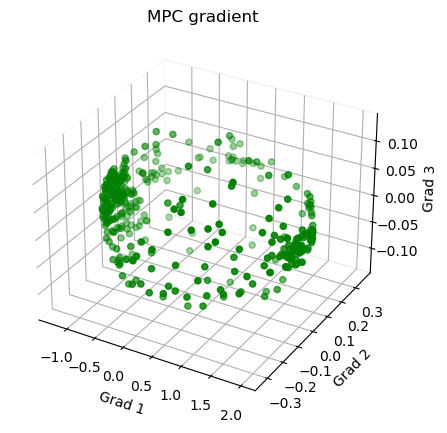

In [25]:
# Plot the gradients
g1 = gm.gradients_[:, 0]
g2 = gm.gradients_[:, 1]
g3 = gm.gradients_[:, 2]

# Creating figure
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

# Creating plot
ax.scatter3D(g1, g2, g3, color = 'green')
plt.title("MPC gradient")

ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')

# Remove the outer box lines
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Show plot
plt.show()

### Mean group MPC gradients on `fsLR-32k` surface

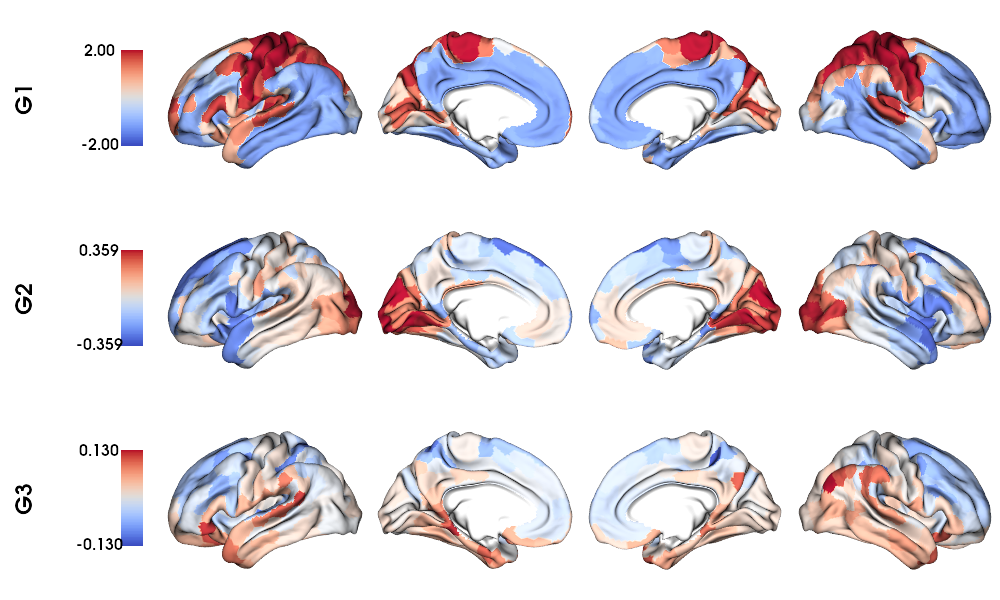

In [26]:
# Map gradients to original parcels
grad = [None] * Nplot
for i, g in enumerate(gm.gradients_.T[0:Nplot,:]):
    grad[i] = map_to_labels(g, labels_f32k, fill=np.nan, mask=mask_f32k)

# Plot Gradients
plot_hemispheres(f32k_lh, f32k_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':labels}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1), color_range = 'sym' )